# Using POPCON to Compute Fluxes and Inductances Over Ramp-Up and Flattop in a Time-Indendent Manner

In this notebook a demonstration of the methodology used to calculate an estimate of the flux consumption over the ramp-up for time-independent POPCONs is shown.

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cfspopcon
from cfspopcon.unit_handling import ureg, Quantity
from cfspopcon.algorithm_class import Algorithm, CompositeAlgorithm
from cfspopcon import named_options

# Change to the top-level directory. Required to find radas_dir in its default location.
%cd {Path(cfspopcon.__file__).parents[1]}
# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")


/Users/isaacsavona/Documents/CFS/cfspopcon24/cfspopcon
Running in /Users/isaacsavona/Documents/CFS/cfspopcon24/cfspopcon


/Users/isaacsavona/Documents/CFS/cfspopcon24/cfspopcon/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Defining a `Machine` object to store info about tokamaks from all over the world!

In [2]:
class Machine:
    def __init__(self, B0, R0, a, delta, kappa, Ip): 
        self.magnetic_field_on_axis = Quantity(B0, ureg.T)
        self.major_radius           = Quantity(R0, ureg.m)
        self.minor_radius           = Quantity(a, ureg.m)
        self.triangularity_psi95    = Quantity(delta, ureg.dimensionless)
        self.inverse_aspect_ratio   = a / R0
        self.areal_elongation       = Quantity(kappa, ureg.dimensionless)
        self.plasma_current         = Quantity(Ip, ureg.MA)

machine = dict()
machine["SPARCV1D"] = Machine(B0=12.3, R0=1.845, a=0.565, delta=0.55, kappa=1.7, Ip=8.7)
machine["SPARCV0D"] = Machine(B0=12,   R0=1.65,  a=0.56, delta=0.32,  kappa=1.8, Ip=7.5)
machine["JT60-SA"]  = Machine(B0=2.72, R0=3.01,  a=1.14, delta=0.57,  kappa=1.85, Ip=5.5) # https://fire.pppl.gov/iaea06_ftp7_5_matsukawa.pdf
machine["DIII-D"]   = Machine(B0=2.6,  R0=1.66,  a=0.67, delta=0.45,  kappa=1.76, Ip=1.2) # https://escholarship.org/content/qt78k0v04v/qt78k0v04v_noSplash_c44c701847deffab65024dd9ceff9c59.pdf?t=p15pc5
machine["ITER"]     = Machine(B0=5.3,  R0=6.2,   a=2.0, delta=0.33,   kappa=1.70, Ip=15.0) # https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=585f5eb3f62f3bd76f3d667c1df357562f54c084
machine["KSTAR"]    = Machine(B0=3.5,  R0=1.8,   a=0.5, delta=0.8,    kappa=2.0, Ip=2.0) # https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=585f5eb3f62f3bd76f3d667c1df357562f54c084
machine["FIRE"]     = Machine(B0=10.0, R0=2.0,   a=0.525, delta=0.4,  kappa=1.8, Ip=6.5) # https://fire.pppl.gov/Snowmass_BP/FIRE.pdf
machine["ASDEX-U"]  = Machine(B0=2.5,  R0=1.65,  a=0.5, delta=0.4,    kappa=1.8, Ip=1.4) # https://www.ipp.mpg.de/16208/einfuehrung
machine["JET"]      = Machine(B0=3.6,  R0=2.96,  a=1.25, delta=0.45,  kappa=1.68, Ip=5) # https://www.ipp.mpg.de/16701/jet
machine["EAST"]     = Machine(B0=3.5,  R0=1.85,  a=0.45, delta=0.8,   kappa=2.0, Ip=1.0) # https://iopscience.iop.org/article/10.1088/1009-0630/13/1/01
machine["ALC-CMOD"] = Machine(B0=9.5,  R0=0.64,  a=0.21, delta=0.5,   kappa=1.8, Ip=2.02) # https://www-internal.psfc.mit.edu/research/alcator/data/fst_cmod.pdf

### Update dataset and calcualte inductances and fluxes during flattop

In [3]:
algorithms = [
    "calc_minor_radius_from_inverse_aspect_ratio",
    "calc_plasma_poloidal_circumference",
    "calc_plasma_volume",
    "calc_elongation_at_psi95_from_areal_elongation",
    "calc_average_ion_temp_from_temperature_ratio",
    "calc_f_shaping_for_qstar",
    "calc_q_star_from_plasma_current",
    "calc_beta_toroidal",
    "calc_beta_poloidal",
    "calc_effective_collisionality",
    "calc_ion_density_peaking",
    "calc_electron_density_peaking",
    "calc_bootstrap_fraction",
    "calc_inductive_plasma_current",
    "calc_Spitzer_loop_resistivity",
    "calc_resistivity_trapped_enhancement",
    "calc_neoclassical_loop_resistivity",
    "calc_loop_voltage",
    "calc_cylindrical_edge_safety_factor",
    "calc_internal_inductivity",
    "calc_internal_inductance_for_noncylindrical",
    "calc_external_inductance",
    "calc_vertical_field_mutual_inductance",
    "calc_invmu_0_dLedR",
    "calc_vertical_magnetic_field",
    "calc_internal_flux",
    "calc_external_flux",
    "calc_resistive_flux",
    "calc_poloidal_field_flux",
    "calc_flux_needed_from_solenoid_over_rampup",
    "calc_max_flattop_duration",
    "calc_breakdown_flux_consumption",
]

algs = []

for key in algorithms:
    algs.append(Algorithm.get_algorithm(key))

calc_flux_and_inductance_dependencies = CompositeAlgorithm(algs)

In [4]:
calc_flux_and_inductance_dependencies.run(
    major_radius = machine["SPARCV1D"].major_radius,
    areal_elongation = machine["SPARCV1D"].areal_elongation,
    triangularity_psi95 = machine["SPARCV1D"].triangularity_psi95,
    magnetic_field_on_axis = machine["SPARCV1D"].magnetic_field_on_axis,
    plasma_current = machine["SPARCV1D"].plasma_current,
    inverse_aspect_ratio = machine["SPARCV1D"].inverse_aspect_ratio,
    elongation_ratio_areal_to_psi95 = 1.025,
    average_electron_density = 2.5 * ureg.n20,
    average_electron_temp = 9.0 * ureg.keV,
    ion_to_electron_temp_ratio = 1.0,
    surface_inductance_coefficients = named_options.SurfaceInductanceCoeffs.Barr,
    total_flux_available_from_CS = 35.0 * ureg.Wb,
    ejima_coefficient = 0.6,
    z_effective = 1.5,
    electron_density_peaking_offset = -0.1,
    ion_density_peaking_offset = -0.2,
    temperature_peaking = 2.5,
    dilution = 0.85,
)

<xarray.Dataset>
Dimensions:                           ()
Data variables: (12/52)
    major_radius                      float64 [m] 1.845
    areal_elongation                  float64 [] 1.7
    triangularity_psi95               float64 [] 0.55
    magnetic_field_on_axis            float64 [T] 12.3
    plasma_current                    float64 [MA] 8.7
    inverse_aspect_ratio              float64 0.3062
    ...                                ...
    external_flux                     float64 [Wb] 23.79
    resistive_flux                    float64 [Wb] 12.1
    poloidal_field_flux               float64 [Wb] 12.87
    flux_needed_from_CS_over_rampup   float64 [Wb] 33.47
    max_flattop_duration              float64 [s] 8.478
    breakdown_flux_consumption        float64 [Wb] 0.128

#### Notice that I have used a custom internal inductivity because the cylindrical `l_i` was seen to differ as much as 46% as compared to the `l_i` calculated by the TSC. Because estimations of `l_i` tend not to be reliable -- as a true calculation relies on equilibrium reconstruction -- an `l_i` from simulation is recommended.

In [5]:
### READ VALUES FROM DICTIONARY ###

beta_poloidal                = dataset.get("beta_poloidal")
internal_inductivity         = dataset.get("internal_inductivity")
internal_inductance          = dataset.get("internal_inductance")
external_inductance          = dataset.get("external_inductance")
vertical_field_mutual_inductance = dataset.get("vertical_field_mutual_inductance")
vert_magnetic_field          = dataset.get("vertical_magnetic_field")
areal_elongation             = dataset.get("areal_elongation")
major_radius                 = dataset.get("major_radius")
magnetic_field_on_axis       = dataset.get("magnetic_field_on_axis")

loop_voltage         = dataset.get("loop_voltage")
inverse_aspect_ratio = dataset.get("inverse_aspect_ratio")
plasma_current       = dataset.get("plasma_current")
internal_flux        = dataset.get("internal_flux")
external_flux        = dataset.get("external_flux")
resistive_flux       = dataset.get("resistive_flux")
max_flattop_duration = dataset.get("max_flattop_duration")
poloidal_field_flux  = dataset.get("poloidal_field_flux")
max_flux_for_flattop = dataset.get("total_flux_available_from_CS") - dataset.get("flux_needed_from_CS_over_rampup")

NameError: name 'dataset' is not defined

In [ ]:
print()
print("beta_poloidal:                    ", beta_poloidal.item())
print("internal_inductivity:              ", internal_inductivity.item())
print("internal_inductance:              ", internal_inductance.item())
print("external_inductance:              ", external_inductance.item())
print("vertical_field_mutual_inductance: ", vertical_field_mutual_inductance.item())
print("vertical_magnetic_field:          ", vert_magnetic_field.item())
print("areal_elongation:                 ", areal_elongation.item())
print("major_radius:                     ", major_radius.item())
print("inverse_aspect_ratio  ", inverse_aspect_ratio.item())
print("plasma_current:       ", plasma_current.item())
print("internal_flux:        ", internal_flux.item())
print("external_flux:        ", external_flux.item())
print("resistive_flux:       ", resistive_flux.item())
print("loop_voltage:         ", loop_voltage.item())
print("max_flattop_duration: ", max_flattop_duration.item())
print("magnetic_field_on_axis: ", magnetic_field_on_axis.item())
print("poloidal_field_flux:        ", poloidal_field_flux.item())
R0            = dataset['major_radius']
Ip            = dataset['plasma_current']
print("Total Flux Consumed Over Ramp-Up:                    ", (internal_flux + external_flux + resistive_flux).item())
print("Total Flux Consumed Over Ramp-Up with Rule of Thumb: ", (2e-6*R0*Ip).item().magnitude, " weber")
print("Max Flux for Flattop: ", max_flux_for_flattop.item())


beta_poloidal:                     0.2
internal_inductivity:               0.91
internal_inductance:               1.0549153977274348e-06 henry
external_inductance:               2.726593701661852e-06 henry
vertical_field_mutual_inductance:  1.0293853117575016 dimensionless
vertical_magnetic_field:           1.1001740558137538 tesla
areal_elongation:                  1.7 dimensionless
major_radius:                      1.845 meter
inverse_aspect_ratio   0.3062330623306233 dimensionless
plasma_current:        8700000.0 ampere
internal_flux:         9.177763960228683 weber
external_flux:         23.72136520445811 weber
resistive_flux:        12.135344108941705 weber
loop_voltage:          0.2586284605412541 volt
max_flattop_duration:  8.802518567109344 second
magnetic_field_on_axis:  12.3 tesla
poloidal_field_flux:         12.111055099525787 weber
Total Flux Consumed Over Ramp-Up:                     45.03447327362849 weber
Total Flux Consumed Over Ramp-Up with Rule of Thumb:  32.103  w

**The assumption** here is that at t=0 the flux-consuming terms are 0 webers and so the flux value at flattop is
a reasonable estimate on the change in flux over the ramp-up.

The poloidal flux is included in the estimate for total flux since this function gives the instantaneous flux contribution from the poloidal field coils to the LCFS of the plasma via the vertical field to maintain the toroidal force balance.

We can now do the same calculation of flux consumed over the ramp-up for various machines and compare the method used above with a Rule of Thumb (ROT) and a method employed by `Sugihara`.

In [ ]:
from scipy import constants

def calc_flux_rampup_Sugihara(kappa:float, R:float, a:float, Ip:float) -> float:
    R = R.item().magnitude
    kappa = kappa.item().magnitude
    a = a.item().magnitude
    Ip = Ip.item().magnitude
    A = R/a
    flux_Ind = constants.mu_0*A*a*(np.log(8*A)-1.6)*(Ip*1e6)
    flux_Res = 3.78e-6*(kappa**(0.2))*((R)/((a)**0.8))*((Ip*1e6)**0.8)
    return flux_Res + flux_Ind

def calc_flux_rampup_ROT(R:float, Ip:float) -> float:
    return (2 * R.item().magnitude * Ip.item().magnitude)

def reltol (other, poynt):
    return '{:g}'.format(float('{:.{p}g}'.format(100 * np.abs(other-poynt)/other, p=3)))

With our `Machine` objects we can construct a `DataArray` with the various methods for calculating the flux over the ramp up. Note that the Sugihara method does not explicitly take into account the flux contribution from the vertical field created by the PFCs.


In [ ]:
flux_methods_over_machines = xr.DataArray(
    dims=["machine", "flux_method"],
    coords=dict(
        machine=["ALC-CMOD", "ASDEX-U", "DIII-D", "EAST", "FIRE", "ITER", "JET", "JT60-SA", "KSTAR", "SPARCV1D", "SPARCV0D"],
        flux_method=["Hirsh&MitTaka13", "Hirsh&Barr", "Hirsh&Jean", "Hirsh&MFEF", "Barr&Barr", "ROT", "Sugihara"],
    ),
)
PF_flux_over_machines = flux_methods_over_machines.copy(deep=True)

We can then make other assumptions about falttop parameters across all machines and make a dictionary for the different calculation methods...

In [ ]:
###***Assumed parameters across all machines***###
dataset["beta_poloidal"] = 0.1 
dataset["loop_voltage"] = 0.5 * ureg.volts  # N/A for this calc since not considering flattop
dataset["elongation_ratio_sep_to_areal"] = 1
dataset["triangularity_ratio_sep_to_psi95"] = 1
dataset["ejima_coefficient"] = 0.6
dataset["internal_inductivity"] = 0.91
dataset["total_flux_available_from_CS"] = 0 * ureg.weber  # N/A for these calcs

# dictionary of the various flux calculation methods to make iterating easier
external_flux_method_dict = {
    "Hirsh&MitTaka13": (named_options.SurfaceInductanceCoeffs.Hirshman, named_options.VertMagneticFieldEq.Mit_and_Taka_Eq13),
    "Hirsh&Barr": (named_options.SurfaceInductanceCoeffs.Hirshman, named_options.VertMagneticFieldEq.Barr),
    "Hirsh&Jean": (named_options.SurfaceInductanceCoeffs.Hirshman, named_options.VertMagneticFieldEq.Jean),
    "Hirsh&MFEF": (named_options.SurfaceInductanceCoeffs.Hirshman, named_options.VertMagneticFieldEq.MagneticFusionEnergyFormulary),
    "Barr&Barr": (named_options.SurfaceInductanceCoeffs.Barr, named_options.VertMagneticFieldEq.Barr),
    "ROT": (named_options.SurfaceInductanceCoeffs.Hirshman, named_options.VertMagneticFieldEq.MagneticFusionEnergyFormulary),
    "Sugihara": (named_options.SurfaceInductanceCoeffs.Barr, named_options.VertMagneticFieldEq.Barr),
}

Before we see the results over all machines, it is first nice to see how different flux calculation methods for various components of flux comare for the `SPARCV1D` machine parameters...

In [ ]:
import warnings
warnings.filterwarnings('ignore') # ignore unit strip warning happening with Sugihara and ROT functions
###***RUN CALCULATIONS***###
for machine_name in machine:
    for external_flux_method in external_flux_method_dict:
        if external_flux_method != "ROT" and external_flux_method != "Sugihara":
            dataset["magnetic_field_on_axis"] = machine[machine_name].B0
            dataset["major_radius"] = machine[machine_name].R0
            dataset["minor_radius"] = machine[machine_name].a
            dataset["triangularity_psi95"] = machine[machine_name].delta
            dataset["areal_elongation"] = machine[machine_name].kappa
            dataset["inverse_aspect_ratio"] = machine[machine_name].epsilon
            dataset["plasma_current"] = machine[machine_name].Ip
            dataset["surface_inductance_coefficients"] = external_flux_method_dict[external_flux_method][0]
            dataset["vertical_magnetic_field_equation"] = external_flux_method_dict[external_flux_method][1]
            dataset = update_flux_and_inductance_dependencies.update_dataset(dataset)
            #Algorithm.get_algorithm('calc_geometry').update_dataset(dataset, in_place=True)
            #Algorithm.get_algorithm('calc_inductances').update_dataset(dataset, in_place=True)
            #Algorithm.get_algorithm('calc_fluxes').update_dataset(dataset, in_place=True)
            # STORE VALUES
            PF_flux_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = dataset["poloidal_field_flux"]
            if machine_name == "SPARCV1D":
                SPARCV1D_external_flux = dataset.get("external_flux").item()
                SPARCV1D_internal_flux = dataset.get("internal_flux").item()
                SPARCV1D_resistive_flux = dataset.get("resistive_flux").item()
                SPARCV1D_PF_flux = dataset.get("poloidal_field_flux").item()
                print(
                    external_flux_method,
                    ": ",
                    "SPARCV1D_resistive_flux ",
                    SPARCV1D_resistive_flux,
                    "SPARCV1D_external_flux ",
                    SPARCV1D_external_flux,
                    "SPARCV1D_internal_flux ",
                    SPARCV1D_internal_flux,
                    "SPARCV1D_PF_flux ",
                    SPARCV1D_PF_flux,
                    "flux_needed_from_CS_for_ramp",
                    dataset.get("flux_needed_from_CS_over_rampup").item(),
                )
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = dataset[
                "flux_needed_from_CS_over_rampup"
            ]
        elif external_flux_method == "ROT":
            ROT_flux = calc_flux_rampup_ROT(dataset.get("major_radius"), dataset.get("plasma_current"))
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = (
                ROT_flux * ureg.weber
            )
        elif external_flux_method == "Sugihara":
            Sugihara_flux = calc_flux_rampup_Sugihara(
                dataset.get("areal_elongation"), dataset.get("major_radius"), dataset.get("minor_radius"), dataset.get("plasma_current")
            )
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = Sugihara_flux * ureg.weber

Hirsh&MitTaka13 :  SPARCV1D_resistive_flux  12.135344108941705 weber SPARCV1D_external_flux  18.5199760409476 weber SPARCV1D_internal_flux  9.177763960228681 weber SPARCV1D_PF_flux  10.305094268122545 weber flux_needed_from_CS_for_ramp 29.527989841995442 weber
Hirsh&Barr :  SPARCV1D_resistive_flux  12.135344108941705 weber SPARCV1D_external_flux  18.5199760409476 weber SPARCV1D_internal_flux  9.177763960228681 weber SPARCV1D_PF_flux  10.263582424119484 weber flux_needed_from_CS_for_ramp 29.569501685998503 weber
Hirsh&Jean :  SPARCV1D_resistive_flux  12.135344108941705 weber SPARCV1D_external_flux  18.5199760409476 weber SPARCV1D_internal_flux  9.177763960228681 weber SPARCV1D_PF_flux  10.654530016440393 weber flux_needed_from_CS_for_ramp 29.178554093677594 weber
Hirsh&MFEF :  SPARCV1D_resistive_flux  12.135344108941705 weber SPARCV1D_external_flux  18.5199760409476 weber SPARCV1D_internal_flux  9.177763960228681 weber SPARCV1D_PF_flux  12.031751649429689 weber flux_needed_from_CS_for_r

Now we can visualize the bar different calculation methods for the flux necessary from the central solenoid over a purely ohmic rampup across various machines. In other words: how much flux is needed from the CS over a purely ohmic rampup? 

['ALC-CMOD' 'ASDEX-U' 'DIII-D' 'EAST' 'FIRE' 'ITER' 'JET' 'JT60-SA'
 'KSTAR' 'SPARCV1D' 'SPARCV0D']


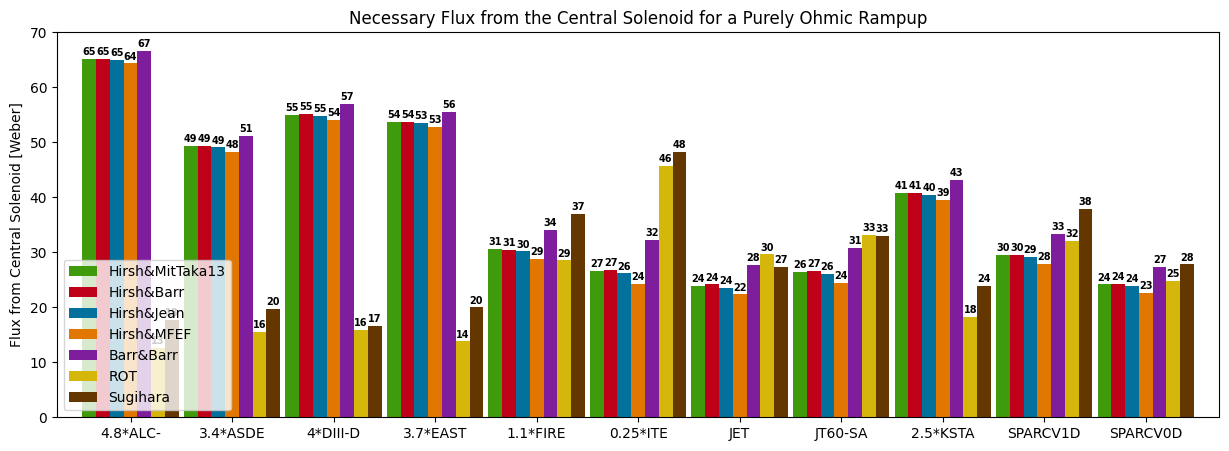

In [ ]:
import pandas as pd

###***Scaling other machines to create a clearer bar plot***###

machine_name = flux_methods_over_machines.coords['machine'].values
scaled_machine_name = machine_name.copy()
print(scaled_machine_name)

scaling_factor_ITER =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ITER")]
scaling_factor_CMOD =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ALC-CMOD")]
scaling_factor_AUG =   flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ASDEX-U")]
scaling_factor_DIIID = flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="DIII-D")]
scaling_factor_EAST =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="EAST")]
scaling_factor_FIRE =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="FIRE")]
scaling_factor_KSTAR = flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="KSTAR")]

scaled_machine_name[5] = str("{:.2g}".format(scaling_factor_ITER.mean().values)) + "*" + scaled_machine_name[5]
scaled_machine_name[0] = str("{:.2g}".format(scaling_factor_CMOD.mean().values)) + "*" + scaled_machine_name[0]
scaled_machine_name[1] = str("{:.2g}".format(scaling_factor_AUG.mean().values)) + "*" + scaled_machine_name[1]
scaled_machine_name[2] = str("{:.2g}".format(scaling_factor_DIIID.mean().values)) + "*" + scaled_machine_name[2]
scaled_machine_name[3] = str("{:.2g}".format(scaling_factor_EAST.mean().values)) + "*" + scaled_machine_name[3]
scaled_machine_name[4] = str("{:.2g}".format(scaling_factor_FIRE.mean().values)) + "*" + scaled_machine_name[4]
scaled_machine_name[8] = str("{:.2g}".format(scaling_factor_KSTAR.mean().values)) + "*" + scaled_machine_name[8]

flux_methods_over_machines.loc[dict(machine="ITER")] = scaling_factor_ITER.mean() * flux_methods_over_machines.loc[dict(machine="ITER")]
flux_methods_over_machines.loc[dict(machine="ALC-CMOD")] = scaling_factor_CMOD.mean() * flux_methods_over_machines.loc[dict(machine="ALC-CMOD")]
flux_methods_over_machines.loc[dict(machine="ASDEX-U")] = scaling_factor_AUG.mean() * flux_methods_over_machines.loc[dict(machine="ASDEX-U")]
flux_methods_over_machines.loc[dict(machine="DIII-D")] = scaling_factor_DIIID.mean() * flux_methods_over_machines.loc[dict(machine="DIII-D")]
flux_methods_over_machines.loc[dict(machine="EAST")] = scaling_factor_EAST.mean() * flux_methods_over_machines.loc[dict(machine="EAST")]
flux_methods_over_machines.loc[dict(machine="FIRE")] = scaling_factor_FIRE.mean() * flux_methods_over_machines.loc[dict(machine="FIRE")]
flux_methods_over_machines.loc[dict(machine="KSTAR")] = scaling_factor_KSTAR.mean() * flux_methods_over_machines.loc[dict(machine="KSTAR")]
flux_methods_over_machines = flux_methods_over_machines.assign_coords(machine=scaled_machine_name)

###***PLOTTING_needed_CS_flux_over_rampup***###
df = pd.DataFrame(
    {
        "Hirsh&MitTaka13": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&MitTaka13"),
        "Hirsh&Barr": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&Barr"),
        "Hirsh&Jean": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&Jean"),
        "Hirsh&MFEF": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&MFEF"),
        "Barr&Barr": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Barr&Barr"),
        "ROT": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="ROT"),
        "Sugihara": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Sugihara"),
    },
    index=scaled_machine_name,
)

ax = df.plot.bar(
    figsize=(15, 5),
    rot=0,
    width=0.95,
    color={
        "Hirsh&MitTaka13": "xkcd:grass green",
        "Hirsh&Barr": "xkcd:scarlet",
        "Hirsh&Jean": "xkcd:ocean blue",
        "Hirsh&MFEF": "xkcd:pumpkin",
        "Barr&Barr": "xkcd:purple",
        "ROT": "xkcd:dark yellow",
        "Sugihara": "xkcd:brown",
    },
)
for p in ax.patches:
    label = "{:.2g}".format(p.get_height())  # Round to two decimal places
    ax.annotate(
        str(label),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=7,
        xytext=(0, 5),
        textcoords="offset points",
        color="black",
        weight="bold",
    )
ax.set_ylabel("Flux from Central Solenoid [Weber]")
ax.set_title("Necessary Flux from the Central Solenoid for a Purely Ohmic Rampup")
ax.legend(loc="lower left")
plt.show()

**N.B** that the poynting method is significantly lower than the Rule of Thumb (ROT) and the Sugihara method, because it explicitly takes into account the flux contribution from the vertical field created by the poloidal field coils.

# Integrating the flux consumption algorithm with the rest of POPCON

It is also of course possible to make a typical `POPCON` plot where the maximum flattop time can be seen in operation space. We've adapted the "SPARC_PRD" example to use the flux consumption algorithm. Therefore, running this calculation over a grid of values is as simple as the following.

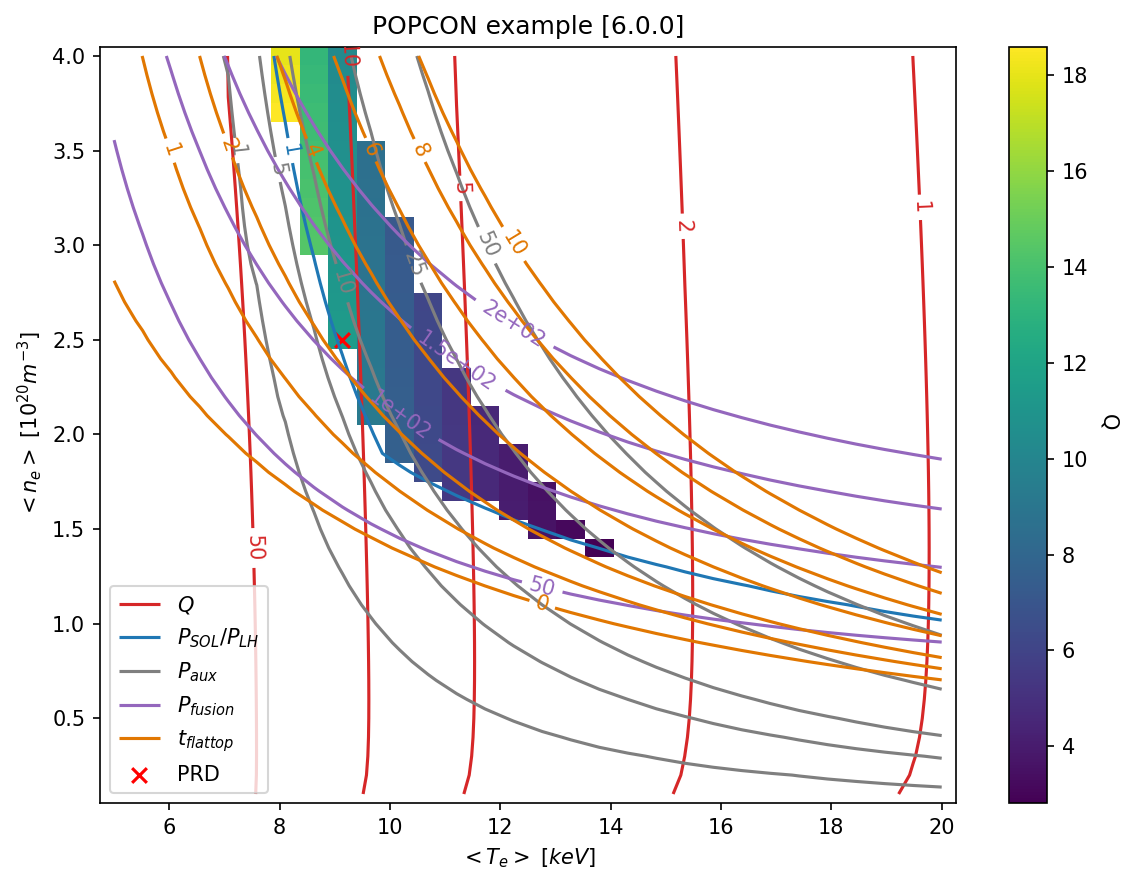

In [ ]:
input_parameters, algorithm, points, plots  = cfspopcon.read_case("example_cases/SPARC_PRD")
algorithm.validate_inputs(input_parameters);

dataset = xr.Dataset(input_parameters)

dataset = algorithm.update_dataset(dataset)

plot_style = cfspopcon.read_plot_style("example_cases/SPARC_PRD/plot_popcon.yaml")

cfspopcon.plotting.make_plot(
    dataset,
    plot_style,
    points=points,
    title="POPCON example",
    output_dir=None
)